### 1. Import required libraries

In [ ]:
import time, requests, os
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from typing import List, Dict
from dotenv import load_dotenv
from ias_openai_langchain import IASOpenaiConversationalLLM, IASOpenaiEmbeddings
from langchain.vectorstores import FAISS
from langchain.vectorstores.chroma import Chroma
from langchain.tools import tool
from pydantic import BaseModel


# tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults


#!pip install pypdf
#!pip install langchain-chroma --upgrade
# !pip install chromadb
# or
# !pip install faiss-cpu

### 2. Initialize the language model

In [ ]:
load_dotenv()
llm = ChatOpenAI('gpt-4o')

### 3. Tools implementation

In [ ]:
# Tool1: implemet Taviliy search tool
#-----------------------------------------
os.environ["TAVILY_API_KEY"] = "..."
tavily_tool = TavilySearchResults(max_results=2)
tavily_tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)fromlangchain_core.runnablesimport RunnableConfig [...] LangGraph Glossary¶\nGraphs¶\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\n\nNodes: Python functions that encode the logic of your agents. They 

In [5]:
# Tool2: implment web_search_tool
#-----------------------------------------
# !pip install -U duckduckgo-search
web_search_tool = DuckDuckGoSearchResults(num_results = 2)
web_search_tool.invoke("Give me the temprature in San Fransisco?")

'snippet: Prolonged Periods of Unsettled Weather into Early Next Week. Showers and thunderstorms with heavy rainfall, with a few thunderstorms being severe, are expected over portions of the Southeast and Mid-Atlantic States through Monday. ... San Francisco CA 37.77°N 122.41°W (Elev. 131 ft) Last Update: 3:03 pm PDT May 3, 2025. Forecast Valid: 8pm ..., title: National Weather Service, link: https://forecast.weather.gov/MapClick.php?textField1=37.784444&textField2=-122.403333, snippet: Currently, in San Francisco, expect winds and a partly cloudy afternoon. The temperature is a breezy 60.8°F, and the feels-like temperature is appraised at a refreshing 57.2°F. The current temperature is the maximum expected temperature of the day., title: Weather today - San Francisco, CA, link: https://www.weather-atlas.com/en/california-usa/san-francisco'

In [6]:
# Tool3: RAG tool
#-----------------------------------------
# 1. Load the doc, 2. Split/Chunk the doc, 3. Vector emnedding and save in vector DB 
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from typing import List
from langchain_core.documents import Document

In [7]:
# 1. Load document
def load_documnet(folder_path: str) -> List[Document]:
    document = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith("pdf"):
            loader = PyPDFLoader(file_path=file_path)
        elif filename.endswith(docx):
            loader = Docx2txtLoader(file_path=file_path)
        else:
            print("Unsupported File!")
        document.extend(loader.load())
    return document

In [8]:
# folder path
folder_path = "./docs"

In [9]:
documents = load_documnet(folder_path = folder_path)
print(f"Number of Documents: {len(documents)}")

Number of Documents: 13


In [10]:
# 2. Chunk the doc
from langchain_text_splitters  import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = len
)

splits = text_splitter.split_documents(documents=documents)

In [ ]:
# 3. Vector embedding and store in vector DB -> Chroma DB
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()


In [12]:
# Create the vector store
embedding_vectore_store = Chroma.from_documents(
    collection_name="my_collection",
    documents=splits,
    embedding=embeddings,
    persist_directory="./chroma_db"
    )

In [13]:
# Basic RAG Tool Schema
class RagToolSchema(BaseModel):
    question: str

In [14]:
# implement RAG tool
@tool(args_schema= RagToolSchema)

# create retriver tool
# ------------------------------------
def retriver_tool(question: str):
    """
    Tool to retrive semantically similar documents to answer 
    related questions related to a company's leave policy
    """

    retiviver = embedding_vectore_store.as_retriever(search_kwargs = {"k": 2})
    retiviver_result = retiviver.invoke(question)
    return "\n\n".join(doc.page_content for doc in retiviver_result)

In [ ]:
# test
ret = embedding_vectore_store.as_retriever(search_kwargs = {"k": 2})
ret.invoke("what is the leave policy?")

In [16]:
# bind the tools with LLM
tools = [tavily_tool, web_search_tool, retriver_tool]
llm_with_tools = llm.bind_tools(tools=tools)

### 4. Graph implementation

In [17]:
# Define the graph 
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
# from langgraph.prebuilt import ToolNode --> did from scratch
# from langgraph.prebuilt import tools_condition --> did from scratch


In [18]:
# Create state
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [19]:
# Create agent node or chatbot node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [20]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [21]:
# create tool node
tool_node = BasicToolNode(tools=tools)

In [22]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [23]:
# creat graph
graph_builder = StateGraph(State)

In [24]:
# add all nodes to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node('tools', tool_node)

In [25]:
# Connect agents and tools using edge and conditional edge
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")

In [26]:
# Compile the graph
graph = graph_builder.compile()

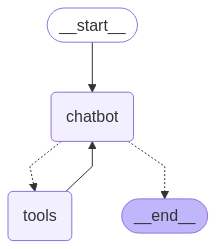

In [27]:
# Display the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [31]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Chat comp payload - what is AutoGenBench in machine learning?
Assistant: AutoGenBench is a tool used in machine learning to automatically generate benchmark datasets. It is designed to help researchers and practitioners evaluate and compare the performance of different machine learning algorithms. The tool uses a variety of techniques to generate synthetic datasets that mimic the characteristics of real-world data, allowing for a more comprehensive and robust evaluation of machine learning models.
Goodbye!
